In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as op
import uncertainties.unumpy as unp
from uncertainties import ufloat
import scipy.constants as const
from uncertainties.unumpy import nominal_values as noms
from uncertainties.unumpy import std_devs as stds
import pandas as pd

## Spektrometermessung mit- und ohne Raumlicht

In [2]:
lam_on, DC_on, C_on = np.genfromtxt("content/data/licht_an.txt", unpack = True)
lam_off, DC_off, C_off = np.genfromtxt("content/data/licht_aus.txt", unpack = True)

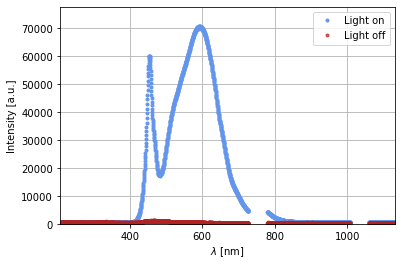

In [3]:
plt.plot(lam_on, C_on, marker = ".", c = "cornflowerblue", label = "Light on", lw = 0)
plt.plot(lam_off, C_off, marker = ".", c = "firebrick", label = "Light off", lw = 0, alpha = .7)
plt.legend();
plt.xlim(min(lam_on), max(lam_on))
plt.ylim(0, 1.1*max(C_on))
plt.ylabel("Intensity [a.u.]")
plt.grid()
plt.xlabel(r"$\lambda$ [nm]");

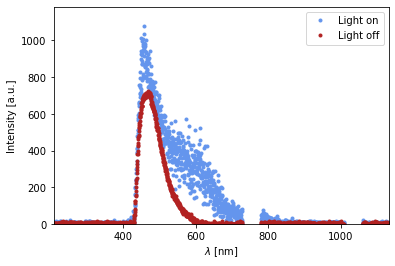

In [4]:
plt.plot(lam_on, C_on - DC_on, marker = ".", c = "cornflowerblue", label = "Light on", lw = 0)
plt.plot(lam_off, C_off - DC_off, marker = ".", c = "firebrick", label = "Light off", lw = 0)
plt.legend();
plt.xlim(min(lam_on), max(lam_on))
plt.ylim(0, 1.1*max(C_on - DC_on))
plt.ylabel("Intensity [a.u.]")
plt.xlabel(r"$\lambda$ [nm]");

$\Rightarrow$ Licht besser ausschalten

## Radialsymmetrie

In [5]:
import itertools

# read all files and store in dataframe

Hs = range(-18, 30, 4)
Vs = range(-6, 34, 4)

data = []

for h, v in itertools.product(Hs, Vs):
    lam, C = np.genfromtxt(f"content/data/radial_2_trohabe/Attenuation_h={h}deg_v={v}deg_x=0mm.txt", unpack = True)
    lam_dc, DC = np.genfromtxt(f"content/data/radial_2_trohabe/DarkCounts_h={h}deg_v={v}deg.txt", unpack = True)
    intensity = np.mean(C-DC) # take mean counts over all lambdas as measure for intensity
    data.append(np.array([h, v, intensity])) 
data = np.array(data)

Text(0.5, 1.0, '2D Intensity Distribution of Light Source')

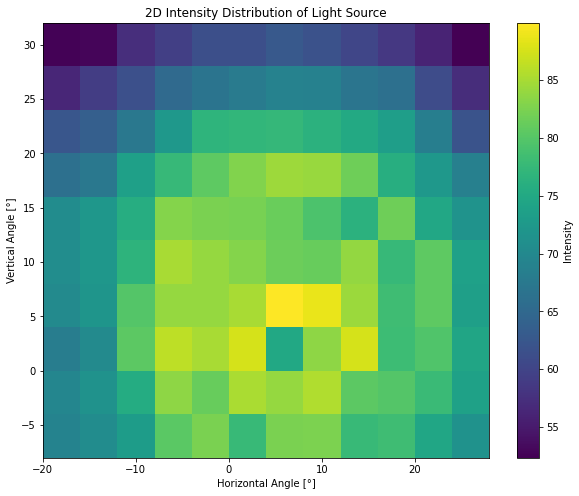

In [6]:
# chat gpt solution
H, V = np.meshgrid(Hs, Vs, indexing='ij')

# Initialize an array for the histogram
histogram = np.zeros(H.shape)

# Populate the histogram array
for i, (h, v, intensity) in enumerate(data):
    hi = np.where(Hs == h)
    vi = np.where(Vs == v)
    histogram[hi, vi] = intensity

# Plot the histogram
plt.figure(figsize=(10, 8))
plt.pcolormesh(H, V, histogram, cmap='viridis')
plt.colorbar(label='Intensity')
plt.xlabel('Horizontal Angle [°]')
plt.ylabel('Vertical Angle [°]')
plt.title('2D Intensity Distribution of Light Source')
#plt.show()

Text(0.5, 1.0, '2D Intensity Distribution of Light Source')

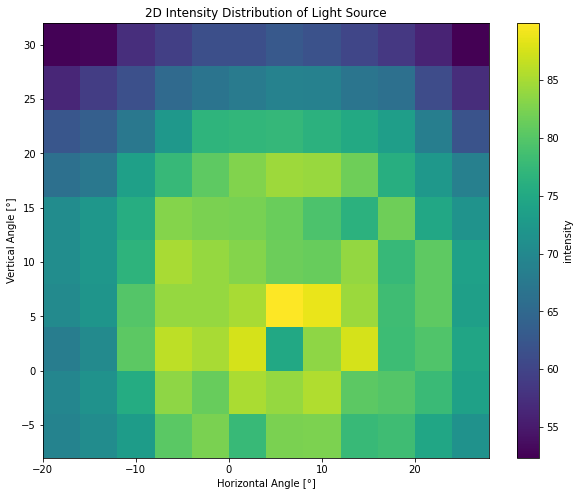

In [7]:

plt.figure(figsize=(10, 8))
plt.hist2d(data[:,0], data[:,1], weights = data[:,2], bins = [np.array(range(-20, 32, 4)), np.array(range(-8, 36, 4))]);
plt.colorbar(label = "intensity");
plt.xlabel('Horizontal Angle [°]')
plt.ylabel('Vertical Angle [°]')
plt.title('2D Intensity Distribution of Light Source')

## Intensitätsmessung

In [143]:
Hs = range(0, 40, 4)
Xs = range(0, 2000, 100)

data = []

for h, x in itertools.product(Hs, Xs):
    lam, C = np.genfromtxt(f"content/data/intensity_2_trohabe/Attenuation_h={h}deg_v=0deg_x={x}mm.txt", unpack = True)
    lam_dc, DC = np.genfromtxt(f"content/data/intensity_2_trohabe/DarkCounts_h={h}deg_v=0deg.txt", unpack = True)
    intensity = np.mean(C-DC) # take mean counts over all lambdas as measure for intensity
    data.append(np.array([h, x, intensity])) 
data = np.array(data)

for h in Hs:
    factor = .97*(data[(data[:,0] == h)][5,2]/data[(data[:,0] == h)][6,2])
    data[(data[:,0] == h) & (data[:,1 ] > 500), 2] *= factor

df = pd.DataFrame(data, columns = ["Theta", "x", "I"])
#data[data[:, 1] > 500 ,2] = data[data[:,1] > 500][:,2] * 2.5 # manipulation of data hehe (the fiber was bent at x = 500)

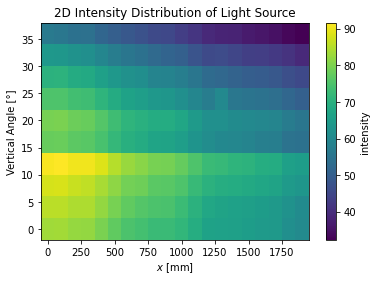

In [145]:
plt.hist2d(df["x"], df["Theta"], weights = df["I"], bins = [np.array(range(-50, 2000, 100)), np.array(range(-2, 40, 4))]);
plt.colorbar(label = "intensity");
plt.xlabel(r'$x$ [mm]')
plt.ylabel('Vertical Angle [°]')
plt.title('2D Intensity Distribution of Light Source');

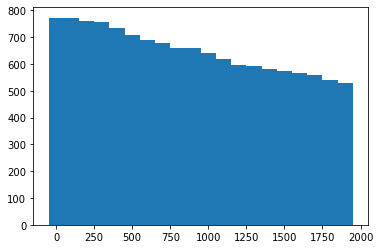

In [146]:
plt.hist(df["x"], weights = df["I"], bins = np.array(range(-50, 2000, 100)));

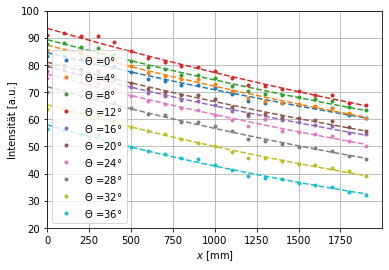

In [237]:
import matplotlib.cm as cm
colors = cm.tab10(np.linspace(0, 1, len(Hs)))

def exp(x, a, I_0):
    return I_0 * np.exp(-a*x)

params, pcov = [], []
x_ = np.linspace(0, 2000, 10000)

for i in range(len(Hs)):
    h = Hs[i]
    x = df["x"][df["Theta"] == h]
    y = df["I"][df["Theta"] == h]
    p1, p2 = op.curve_fit(exp, x, y, p0 = [1/100, np.array(y)[0]])
    params.append(p1)
    pcov.append(p2)
    plt.plot(x, y, c = colors[i], label = r"$\Theta$ =" + f"{h}°", lw = 0, marker = ".")
    plt.plot(x, exp(x, *p1), ls = "dashed", c = colors[i]);

plt.ylabel("Intensität [a.u.]")
plt.xlabel(r"$x$ [mm]")
plt.ylim(20, 100)
plt.xlim(0, 1999)
plt.grid()
plt.legend()
 
params, pcov = np.array(params), np.array(pcov)    

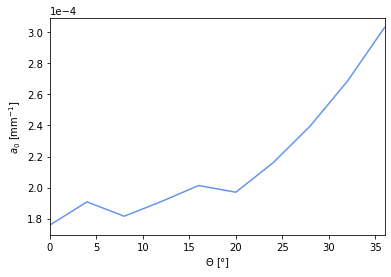

In [251]:
a_avg = np.mean(params[:, 0])

plt.plot(Hs, params[:, 0], color = "cornflowerblue")
plt.ylabel(r"$a_0$ [mm$^{-1}$]")
plt.xlabel(r"$\Theta$ [°]")
plt.xlim(0,36)
plt.ticklabel_format(axis = "y", style = "sci", scilimits = (0,0))

## Winkel Intensitätsmessung

In [12]:
data = []

for h in range(0, 45):
    lam, C = np.genfromtxt(f"content/data/small_angle_trohabe/Attenuation_h={h}deg_v=0deg_x=0mm.txt", unpack = True)
    lam_dc, DC = np.genfromtxt(f"content/data/small_angle_trohabe/DarkCounts_h={h}deg_v=0deg.txt", unpack = True)
    intensity = np.mean(C-DC) # take mean counts over all lambdas as measure for intensity
    data.append(np.array([h, intensity])) 
data = np.array(data)

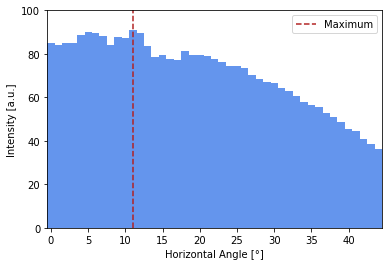

In [13]:
plt.hist(data[:,0], weights = data[:,1], bins = np.linspace(-0.5, 44.5, 46), color = "cornflowerblue");
plt.ylabel("Intensity [a.u.]")
plt.xlabel("Horizontal Angle [°]");
plt.vlines(data[data[:,1] ==max(data[:,1])][0,0], 0, 100, ls = "dashed", color = "firebrick", label = "Maximum")
plt.ylim(0,100);
plt.xlim(-0.5,44.5);
plt.legend();